In [57]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-services-overview") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [58]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-services-overview>

In [59]:
from pathlib import Path

global_data_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/")
global_data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log')

In [60]:
data_dir = global_data_dir / "focused"
data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused')

In [61]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [62]:
top_services = {
    "google": ("Google", "google", "#4285f4"),
    "youtube": ("YouTube", "youtube", "#ff0000"),
    "baidu": ("Baidu", "baidu", "#de0f17"),
    "qq": ("QQ", "qq", "#0052d4"),
    "facebook": ("Facebook", "facebook", "#1877f2"),
    "yahoo": ("Yahoo!", "yahoo", "#410093"),
    "amazon": ("Amazon", "amazon", "#ff9900"),
    "wikimedia": ("Wikipedia", "wikipedia", "#339966"),
    "jd": ("JD.com", "jd-dot-com", "#f30213"),
    "360": ("360", "360", "#07cd5a"),
    "weibo": ("Weibo", "weibo", "#e6162d"),
    "reddit": ("Reddit", "reddit", "#ff4500"),
    "vk": ("Vk.com", "vk-dot-com", "#45668e"),
    "csdn": ("CSDN", "csdn", "#fe5537"),
    "bing": ("Bing", "bing", "#ffb900"),
    "twitter": ("Twitter", "twitter", "#1da1f2"),
    "twitch": ("Twitch", "twitch", "#9146ff"),
    "ebay": ("eBay", "ebay", "#0064d2"),
    "naver": ("Naver", "naver", "#1ec545"),
    "aliexpress": ("AliExpress", "aliexpress", "#ff4747"),
}

In [63]:
def paths_jsonl(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    yield from base_path.glob("*/*.jsonl.gz")

In [64]:
def paths_warc(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    for path in base_path.glob("*/*"):
        if path.is_dir():
            yield path

In [65]:
from gzip import GzipFile


def count_jsonl(path: Path) -> int:
    print(f"Count JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as file:
            return sum(1 for _ in file)
    except:
        return 0

In [66]:
from json import loads, JSONDecodeError
from typing import Iterator

def read_jsonl(path: Path) -> Iterator:
    print(f"Read JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as gzip_file:
            for line in gzip_file:
                try:
                    url = loads(line)
                except JSONDecodeError:
                    continue
                yield url
    except:
        return 

In [67]:
from typing import Optional


def detect_language(text: str) -> Optional[str]:
    text = text.replace("\n", " ")
    # if len(text) < 10:
    #     return None
    from cld3 import get_language
    language_prediction = get_language(text)
    if language_prediction is None:
        return None
    return language_prediction.language.split("-")[0] if language_prediction.is_reliable else None

In [68]:
from bleach import clean

def result_text(result: dict) -> str:
    title_and_text = result["title"]
    if result["snippet"] is not None:
        title_and_text += f" {result['snippet']}"
    title_and_text = clean(
        title_and_text,
        tags=[],
        attributes=[],
        protocols=[],
        strip=True,
        strip_comments=True,
    )
    return title_and_text

In [69]:
with Path("services.txt").open("rt") as file:
    alexa_services = [
        line.strip()
        for line in file
        if line
    ]
len(alexa_services)

1087

In [70]:
years = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
    .map(lambda date: date.year)\
    .distinct()\
    .collect()
year_range = (min(years), max(years) + 1)
year_range

(1999, 2023)

In [71]:
from operator import add
from datetime import datetime
from seaborn import rugplot, FacetGrid, set_theme
from pandas import DataFrame

def service_overview(service: str) -> str:
    set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    name, logo, color = top_services[service]
    print(f"Create summary for service {name}.")
    
    num_urls = sc.parallelize(paths_jsonl(service, "archived-urls"), 1000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_urls:,.0f} URLs")
    
    num_queries = sc.parallelize(paths_jsonl(service, "archived-query-urls"), 1000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_queries:,.0f} queries")
    
    num_unique_queries = sc.parallelize(paths_jsonl(service, "archived-query-urls"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda url: url["query"])\
        .distinct()\
        .count()
    print(f"\t{num_unique_queries:,.0f} unique queries")
    
    num_serps = sc.parallelize(paths_jsonl(service, "archived-parsed-serps"), 1000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_serps:,.0f} SERPs")
    
    num_search_results = sc.parallelize(paths_jsonl(service, "archived-parsed-serps"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: len(serp["results"]) if "results" in serp else 0)\
        .aggregate(0, add, add)
    print(f"\t{num_search_results:,.0f} results")
    
    most_frequent_query_languages = sc.parallelize(paths_jsonl(service, "archived-query-urls"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda query: query["query"])\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tQuery languages: {', '.join(most_frequent_query_languages)}")
    
    most_frequent_snippet_languages = sc.parallelize(paths_jsonl(service, "archived-parsed-serps"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(1000)\
        .map(result_text)\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tSnippet languages: {', '.join(most_frequent_snippet_languages)}")
    
    query_timeline = sc.parallelize(paths_jsonl(service, "archived-query-urls"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    query_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in query_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    query_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    query_timeline_plot.figure.tight_layout()
    query_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    query_timeline_plot.despine(bottom=True, left=True)
    query_timeline_plot.savefig(f"figures/timelines/{service}-queries.png")
    query_timeline_plot.savefig(f"figures/timelines/{service}-queries.pdf")
    if len(query_timeline) > 0:
        print(f"\tQueries timeline: {min(query_timeline)} to {max(query_timeline)}")
    else:
        print(f"\tQueries timeline: none")
    
    result_timeline = sc.parallelize(paths_jsonl(service, "archived-parsed-serps"), 1000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(1000)\
        .map(lambda result: datetime.fromtimestamp(result["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    result_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in result_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    result_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    result_timeline_plot.figure.tight_layout()
    result_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    result_timeline_plot.despine(bottom=True, left=True)
    result_timeline_plot.savefig(f"figures/timelines/{service}-results.png")
    result_timeline_plot.savefig(f"figures/timelines/{service}-results.pdf")
    if len(result_timeline) > 0:
        print(f"\Results timeline: {min(result_timeline)} to {max(result_timeline)}")
    else:
        print(f"\Results timeline: none")
    
    return fr"\servicelogo{{{logo}}} & {name} & {num_urls:,.0f} & {num_queries:,.0f} & {num_unique_queries:,.0f} & {', '.join(most_frequent_query_languages)} & \servicetimeline{{{service}-queries}} & {num_serps:,.0f} & {num_search_results:,.0f} & {', '.join(most_frequent_snippet_languages)} & \servicetimeline{{{service}-results}} \\"

In [72]:
# print(service_overview("yahoo"))

In [73]:
def top_services_overview() -> str:
    return "\n".join([
        service_overview(service)
        for service in top_services
    ])

Create summary for service Google.
	89,364,948 URLs
	72,673,044 queries
	19,953,592 unique queries
	785,814 SERPs
	6,265,179 results
	Query languages: en, th, zh
	Snippet languages: en, de, pt


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2000, 4, 22) to (2022, 11, 9)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2003, 1, 13) to (2022, 11, 8)
Create summary for service YouTube.
	41,846,525 URLs
	41,365,166 queries
	11,250,179 unique queries
	1,184,860 SERPs
	25,233,781 results
	Query languages: ru, ko, ja
	Snippet languages: ru, en, ko


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2006, 8, 8) to (2022, 11, 9)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2007, 2, 16) to (2021, 11, 16)
Create summary for service Baidu.
	78,506,825 URLs
	69,619,339 queries
	2,900,878 unique queries
	492,028 SERPs
	1,975,625 results
	Query languages: zh, ga, ja
	Snippet languages: zh, en, mr


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2005, 1, 31) to (2022, 11, 9)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2006, 1, 29) to (2022, 11, 2)
Create summary for service QQ.
	515,895 URLs
	513,608 queries
	51,228 unique queries
	29,991 SERPs
	0 results
	Query languages: zh, ja, lb
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2011, 3, 27) to (2021, 10, 20)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service Facebook.
	3,131,212 URLs
	159,087 queries
	35,492 unique queries
	553 SERPs
	0 results
	Query languages: ca, en, bs
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2007, 10, 23) to (2022, 11, 8)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service Yahoo!.
	8,787,707 URLs
	2,827,103 queries
	1,232,589 unique queries
	1,021,819 SERPs
	8,677,259 results
	Query languages: en, la, de
	Snippet languages: en, es, pt


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (1999, 7, 26) to (2022, 9, 21)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2000, 1, 8) to (2022, 9, 21)
Create summary for service Amazon.
	66,795,164 URLs
	776,127 queries
	315,068 unique queries
	102,031 SERPs
	2,659,675 results
	Query languages: en, ja, zh
	Snippet languages: en, ja, it


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2003, 5, 29) to (2022, 9, 22)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2019, 4, 25) to (2022, 9, 22)
Create summary for service Wikipedia.
	68,547,509 URLs
	1,707,058 queries
	621,971 unique queries
	0 SERPs
	0 results
	Query languages: sv, zh, en
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2010, 10, 8) to (2022, 11, 9)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service JD.com.
	4,370,884 URLs
	3,902,604 queries
	370,473 unique queries
	0 SERPs
	0 results
	Query languages: zh, hr, ja
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2013, 3, 23) to (2022, 11, 8)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service 360.
	1,495,365 URLs
	1,090,152 queries
	65,596 unique queries
	30,503 SERPs
	253,457 results
	Query languages: zh, ja, mg
	Snippet languages: zh, mr, en


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2012, 9, 27) to (2022, 10, 24)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2013, 3, 30) to (2022, 10, 23)
Create summary for service Weibo.
	6,245,012 URLs
	5,324,385 queries
	1,886,458 unique queries
	27,828 SERPs
	0 results
	Query languages: zh, ja, en
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins c

	Queries timeline: (2005, 10, 23) to (2022, 9, 21)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service Reddit.
	94,162 URLs
	89,492 queries
	36,852 unique queries
	0 SERPs
	0 results
	Query languages: en, la, de
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2005, 12, 12) to (2022, 11, 9)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service Vk.com.
	643,354 URLs
	153,642 queries
	46,134 unique queries
	0 SERPs
	0 results
	Query languages: ru, sr, ky
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2012, 1, 6) to (2022, 11, 8)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service CSDN.
	21,863 URLs
	946 queries
	736 unique queries
	0 SERPs
	0 results
	Query languages: zh, en, vi
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2021, 2, 23) to (2022, 11, 8)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service Bing.
	11,263,539 URLs
	6,152,425 queries
	2,253,965 unique queries
	1,115,786 SERPs
	5,947,107 results
	Query languages: en, zh, pt
	Snippet languages: en, pt, fr


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2009, 6, 5) to (2022, 9, 21)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2009, 7, 16) to (2022, 9, 21)
Create summary for service Twitter.
	55,499,532 URLs
	48,084,528 queries
	3,869,382 unique queries
	9,077 SERPs
	118,576 results
	Query languages: ja, en, gl
	Snippet languages: en, ja, es


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2008, 8, 28) to (2022, 11, 11)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2012, 6, 12) to (2022, 6, 14)
Create summary for service Twitch.
	21,931 URLs
	15,225 queries
	11,445 unique queries
	0 SERPs
	0 results
	Query languages: en, zh, de
	Snippet languages: 


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2019, 7, 20) to (2022, 11, 9)


/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: none
Create summary for service eBay.
	7,927,123 URLs
	5,507,532 queries
	1,379,646 unique queries
	168,937 SERPs
	2,002,188 results
	Query languages: zh, en, la
	Snippet languages: en, es, de


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2009, 7, 27) to (2022, 11, 9)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2012, 2, 29) to (2022, 8, 30)
Create summary for service Naver.
	1,063,991 URLs
	756,153 queries
	400,490 unique queries
	334,490 SERPs
	3,376,741 results
	Query languages: ja, ko, vi
	Snippet languages: ko, en, hi


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (1999, 9, 1) to (2022, 9, 21)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2000, 9, 25) to (2022, 9, 21)
Create summary for service AliExpress.
	4,620,331 URLs
	1,861,642 queries
	55,849 unique queries
	20,692 SERPs
	165,108 results
	Query languages: en, lb, fy
	Snippet languages: en, fr, ru


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2009, 12, 20) to (2022, 11, 8)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/3067079226.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2010, 2, 2) to (2019, 7, 11)
\servicelogo{google} & Google & 89,364,948 & 72,673,044 & 19,953,592 & en, th, zh & \servicetimeline{google-queries} & 785,814 & 6,265,179 & en, de, pt & \servicetimeline{google-results} \\
\servicelogo{youtube} & YouTube & 41,846,525 & 41,365,166 & 11,250,179 & ru, ko, ja & \servicetimeline{youtube-queries} & 1,184,860 & 25,233,781 & ru, en, ko & \servicetimeline{youtube-results} \\
\servicelogo{baidu} & Baidu & 78,506,825 & 69,619,339 & 2,900,878 & zh, ga, ja & \servicetimeline{baidu-queries} & 492,028 & 1,975,625 & zh, en, mr & \servicetimeline{baidu-results} \\
\servicelogo{qq} & QQ & 515,895 & 513,608 & 51,228 & zh, ja, lb & \servicetimeline{qq-queries} & 29,991 & 0 &  & \servicetimeline{qq-results} \\
\servicelogo{facebook} & Facebook & 3,131,212 & 159,087 & 35,492 & ca, en, bs & \servicetimeline{facebook-queries} & 553 & 0 &  & \servicetimeline{facebook-results} \\
\servicelogo{yahoo} & Yahoo! & 8,787,707 & 2,827,103 & 1,232,589 &

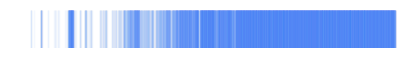

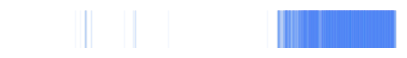

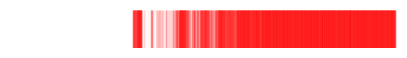

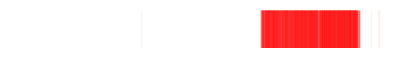

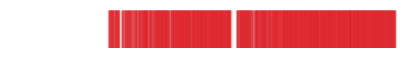

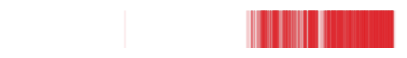

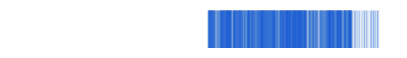

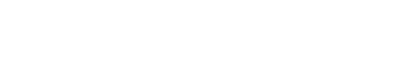

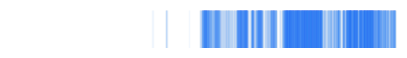

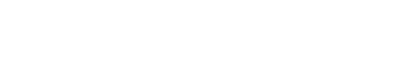

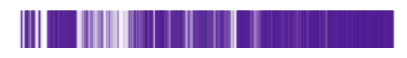

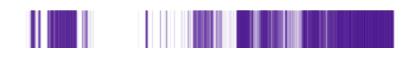

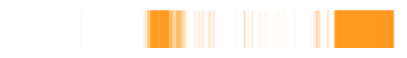

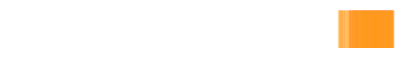

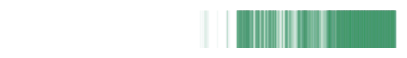

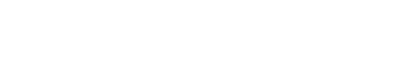

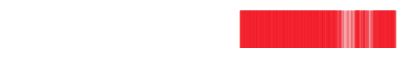

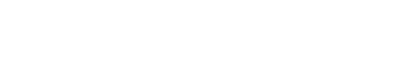

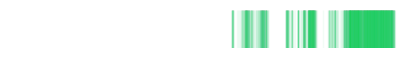

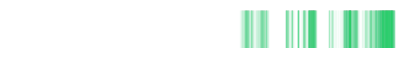

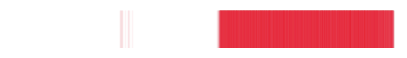

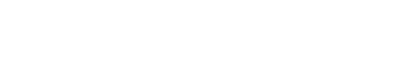

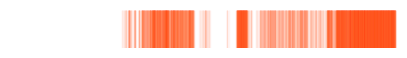

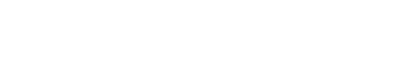

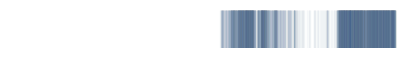

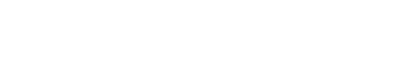

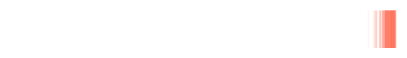

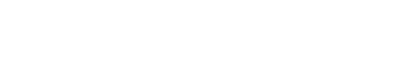

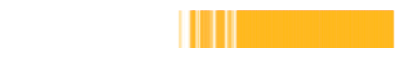

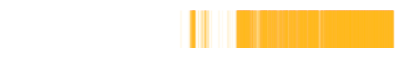

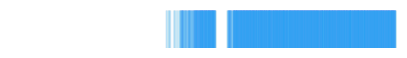

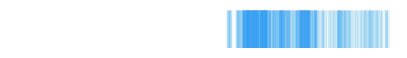

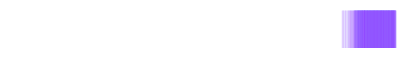

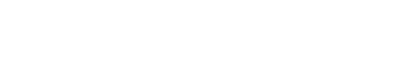

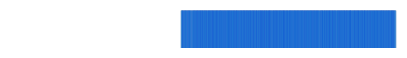

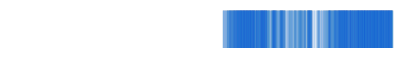

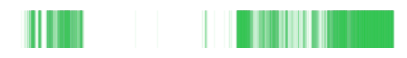

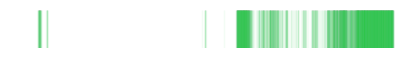

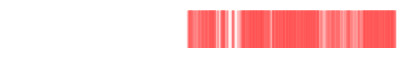

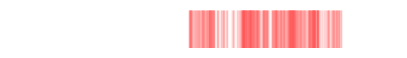

In [74]:
print(top_services_overview())

In [75]:
from operator import add
from datetime import datetime
from seaborn import rugplot, FacetGrid, set_theme
from pandas import DataFrame

def remaining_overview() -> str:
    set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    name = "others"
    color = "#646464"
    
    print(f"Create remaining summary.")
    
    num_urls = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-urls"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_urls:,.0f} URLs")
    
    num_queries = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_queries:,.0f} queries")
    
    num_unique_queries = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda url: url["query"])\
        .distinct()\
        .count()
    print(f"\t{num_unique_queries:,.0f} unique queries")
    
    num_serps = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_serps:,.0f} SERPs")
    
    num_search_results = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: len(serp["results"]) if "results" in serp else 0)\
        .aggregate(0, add, add)
    print(f"\t{num_search_results:,.0f} results")
    
    most_frequent_query_languages = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda query: query["query"])\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tQuery languages: {', '.join(most_frequent_query_languages)}")
    
    most_frequent_snippet_languages = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(10_000)\
        .map(result_text)\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tSnippet languages: {', '.join(most_frequent_snippet_languages)}")
    
    query_timeline = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    query_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in query_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    query_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    query_timeline_plot.figure.tight_layout()
    query_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    query_timeline_plot.despine(bottom=True, left=True)
    query_timeline_plot.savefig(f"figures/timelines/remaining-queries.png")
    query_timeline_plot.savefig(f"figures/timelines/remaining-queries.pdf")
    if len(query_timeline) > 0:
        print(f"\tQueries timeline: {min(query_timeline)} to {max(query_timeline)}")
    else:
        print(f"\tQueries timeline: none")
    
    result_timeline = sc.parallelize(alexa_services, 1000)\
        .filter(lambda service: service not in top_services.keys())\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(10_000)\
        .map(lambda result: datetime.fromtimestamp(result["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    result_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in result_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    result_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    result_timeline_plot.figure.tight_layout()
    result_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    result_timeline_plot.despine(bottom=True, left=True)
    result_timeline_plot.savefig(f"figures/timelines/remaining-results.png")
    result_timeline_plot.savefig(f"figures/timelines/remaining-results.pdf")
    if len(result_timeline) > 0:
        print(f"\Results timeline: {min(result_timeline)} to {max(result_timeline)}")
    else:
        print(f"\Results timeline: none")
    
    return fr"\hspace{{0.4em}}\rotatebox{{90}}{{...}} & {len(alexa_services) - len(top_services)}~others & {num_urls:,.0f} & {num_queries:,.0f} & {num_unique_queries:,.0f} & {', '.join(most_frequent_query_languages)} & \servicetimeline{{remaining-queries}} & {num_serps:,.0f} & {num_search_results:,.0f} & {', '.join(most_frequent_snippet_languages)} & \servicetimeline{{remaining-results}} \\"

Create remaining summary.
	558,972,258 URLs
	93,841,976 queries
	20,639,713 unique queries
	139,604 SERPs
	1,608,078 results
	Query languages: en, zh, de
	Snippet languages: en, zh, de


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/109893563.py:121: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (2000, 4, 7) to (2022, 11, 11)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/109893563.py:163: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2005, 2, 24) to (2022, 11, 11)
\hspace{0.4em}\rotatebox{90}{...} & 1067~others & 558,972,258 & 93,841,976 & 20,639,713 & en, zh, de & \servicetimeline{remaining-queries} & 139,604 & 1,608,078 & en, zh, de & \servicetimeline{remaining-results} \\


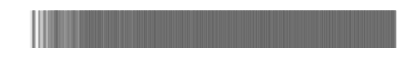

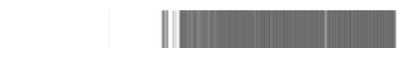

In [76]:
print(remaining_overview())

In [77]:
from operator import add
from datetime import datetime
from seaborn import rugplot, FacetGrid, set_theme
from pandas import DataFrame

def all_overview() -> str:
    set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    name = "others"
    color = "#646464"
    
    print(f"Create all summary.")
    
    num_urls = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-urls"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_urls:,.0f} URLs")
    
    num_queries = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_queries:,.0f} queries")
    
    num_unique_queries = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda url: url["query"])\
        .distinct()\
        .count()
    print(f"\t{num_unique_queries:,.0f} unique queries")
    
    num_serps = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .map(count_jsonl)\
        .aggregate(0, add, add)
    print(f"\t{num_serps:,.0f} SERPs")
    
    num_search_results = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: len(serp["results"]) if "results" in serp else 0)\
        .aggregate(0, add, add)
    print(f"\t{num_search_results:,.0f} results")
    
    most_frequent_query_languages = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda query: query["query"])\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tQuery languages: {', '.join(most_frequent_query_languages)}")
    
    most_frequent_snippet_languages = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(10_000)\
        .map(result_text)\
        .map(detect_language)\
        .filter(lambda language: language is not None)\
        .keyBy(lambda language: language)\
        .mapValues(lambda _: 1)\
        .reduceByKey(add)\
        .sortBy(lambda language_counts: language_counts[1], ascending=False)\
        .map(lambda language_counts: language_counts[0])\
        .take(3)
    print(f"\tSnippet languages: {', '.join(most_frequent_snippet_languages)}")
    
    query_timeline = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda query: datetime.fromtimestamp(query["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    query_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in query_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    query_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    query_timeline_plot.figure.tight_layout()
    query_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    query_timeline_plot.despine(bottom=True, left=True)
    query_timeline_plot.savefig(f"figures/timelines/all-queries.png")
    query_timeline_plot.savefig(f"figures/timelines/all-queries.pdf")
    if len(query_timeline) > 0:
        print(f"\tQueries timeline: {min(query_timeline)} to {max(query_timeline)}")
    else:
        print(f"\tQueries timeline: none")
    
    result_timeline = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-parsed-serps"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda serp: serp["results"])\
        .filter(lambda results: results is not None)\
        .flatMap(lambda results: results)\
        .repartition(10_000)\
        .map(lambda result: datetime.fromtimestamp(result["timestamp"]))\
        .map(lambda date: (date.year, date.month, date.day))\
        .distinct()\
        .collect()
    result_timeline_plot = FacetGrid(
        data=DataFrame([
            {"year": year + (month - 1) / 12 + (day - 1) / 356}
            for year, month, day in result_timeline
        ]),
        height=0.5,
        aspect=10,
        xlim=year_range,
        ylim=(0,1),
    )
    result_timeline_plot.map_dataframe(
        rugplot,
        x="year",
        height=1,
        lw=0.1,
        alpha=0.05,
        hue=0,
        palette=[color],
    )
    result_timeline_plot.figure.tight_layout()
    result_timeline_plot.set(title="", xticks=[], xlabel="", yticks=[], ylabel="")
    result_timeline_plot.despine(bottom=True, left=True)
    result_timeline_plot.savefig(f"figures/timelines/all-results.png")
    result_timeline_plot.savefig(f"figures/timelines/all-results.pdf")
    if len(result_timeline) > 0:
        print(f"\Results timeline: {min(result_timeline)} to {max(result_timeline)}")
    else:
        print(f"\Results timeline: none")
    
    return fr"\(\sum\) & {len(alexa_services)}~providers & {num_urls:,.0f} & {num_queries:,.0f} & {num_unique_queries:,.0f} & {', '.join(most_frequent_query_languages)} & \servicetimeline{{all-queries}} & {num_serps:,.0f} & {num_search_results:,.0f} & {', '.join(most_frequent_snippet_languages)} & \servicetimeline{{all-results}} \\"

Create all summary.
	1,009,735,130 URLs
	356,421,234 queries
	64,544,345 unique queries
	5,464,013 SERPs
	58,282,774 results
	Query languages: zh, en, ga
	Snippet languages: en, ru, ko


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/2187545317.py:113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  query_timeline_plot.figure.tight_layout()


	Queries timeline: (1999, 7, 26) to (2022, 11, 11)


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_228341/2187545317.py:154: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  result_timeline_plot.figure.tight_layout()


\Results timeline: (2000, 1, 8) to (2022, 11, 11)
\(\sum\) & 1087~providers & 1,009,735,130 & 356,421,234 & 64,544,345 & zh, en, ga & \servicetimeline{all-queries} & 5,464,013 & 58,282,774 & en, ru, ko & \servicetimeline{all-results} \\


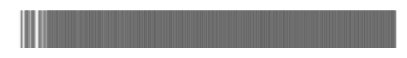

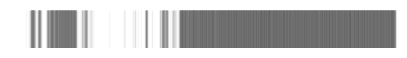

In [78]:
print(all_overview())